        # Тройное экспоненциальное сглаживание

In [19]:
import warnings

warnings.filterwarnings('ignore')

from catboost import CatBoostRegressor

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams

rcParams['figure.figsize'] = 7, 5

### Предобработка временного ряда  <a name="preprocess">

Возьмем датасет, который нам дан на kaggle.

In [20]:
df = pd.read_csv("Bitcoin_kaggle.csv", sep=';', thousands=',')

df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jul 14, 2023",30346.4,29912.7,30442.0,29757.4,46.42K,1.45%
1,"Jul 13, 2023",30346.4,29912.7,30442.0,29757.4,46.42K,1.45%
2,"Jul 12, 2023",30346.4,29912.7,30442.0,29757.4,46.42K,1.45%
3,"Jul 11, 2023",30346.4,29912.7,30442.0,29757.4,46.42K,1.45%
4,"Jul 10, 2023",30346.4,29912.7,30442.0,29757.4,46.42K,1.45%


In [21]:
df.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

Нам понадобится колонка с датами, но сперва нужно ее преобразовать из строки в timestamp.

In [22]:
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
df.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %            object
dtype: object

In [23]:
df = df[['Date', 'Price']].set_index('Date')

In [24]:
df = df.sort_index()
df.head()

,Price
Date,
2022-01-14,43073.3
2022-01-15,43097.0
2022-01-16,43079.1
2022-01-17,42209.3
2022-01-18,42364.6


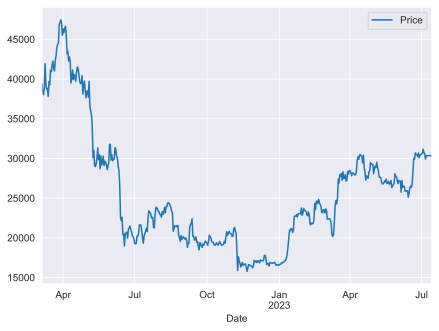

In [25]:
df[50:].plot();

### Тройное экспоненциальное сглаживание (модель Хольта-Винтерса с трендом и сезонностью)

Рассмотрим две модели:

1) Модель с аддитивными трендом и сезонностью

2) Модель с аддитивным трендом и мультипликативной сезонностью

Модель (с аддитивным трендом и сезонностью периода $p$) имеет вид
$$\tilde y_{t+d} = \tilde l_t + \tilde b_t\cdot d + \tilde s_{t+d mod(p)-p},$$
где
$$\tilde l_t = \alpha(y_t-\tilde s_{t-p}) + (1-\alpha)(\tilde l_{t-1}+\tilde b_{t-1}),$$
$$\tilde b_t = \beta(\tilde l_t - \tilde l_{t-1}) + (1-\beta)\tilde b_{t-1},$$
$$\tilde s_t = \gamma(y_t-\tilde l_t) + (1-\gamma)\tilde s_{t-p}$$

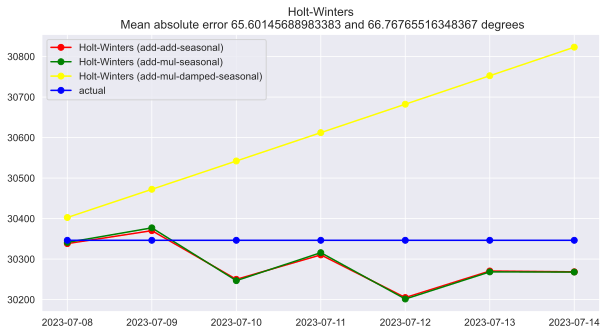

In [30]:
test_index = len(df) - 7

fit1 = ExponentialSmoothing(
    df[:test_index],
    seasonal_periods=7,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit2 = ExponentialSmoothing(
    df[:test_index],
    seasonal_periods=7,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit3 = Holt(df[:test_index], exponential=True, initialization_method="estimated").fit()

plt.show()

preds_add = fit1.forecast(7)
preds_mul = fit2.forecast(7)
preds_HOLT = fit3.forecast(7)

plt.figure(figsize=(10, 5))
plt.plot(preds_add, "r", marker="o", color="red", label="Holt-Winters (add-add-seasonal)")
plt.plot(preds_mul, "r", marker="o", color="green", label="Holt-Winters (add-mul-seasonal)")
plt.plot(preds_HOLT, "r", marker="o", color="yellow", label="Holt")
plt.plot(df[test_index:], marker="o", color="blue", label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Holt-Winters\n Mean absolute error {mean_absolute_error(preds_add, df[test_index:])} and {mean_absolute_error(preds_mul, df[test_index:])} degrees");

Теперь сохраним результат.

In [27]:
ans = pd.read_csv("prediction_baseline.csv")

ans['Price'] = preds_add.array
ans.to_csv('Holt-Winters_(add-add-seasonal).csv', header=True, index=False)

ans['Price'] = preds_mul.array
ans.to_csv('Holt-Winters_(add-mul-seasonal).csv', header=True, index=False)

ans['Price'] = preds_HOLT.array
ans.to_csv('Holt.csv', header=True, index=False)